In [1]:
!pip install datasets diffusers transformers accelerate

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# 1. Load Dataset
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [3]:
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
max_tokens=max_tokens,
output_sequence_length=seq_len,
)
# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [4]:
def preprocess_fn(item):
    # Proses gambar
    image = item["image"].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0

    # Proses teks
    caption = item["text"]
    return caption, image
def generator():
    for item in raw_dataset:
        yield preprocess_fn(item)
train_ds = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE)


In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs, context):
        attn_output = self.att(inputs, context)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


In [6]:
def build_transformer(
    vocab_size_text=5000,
    vocab_size_visual=1024,
    seq_len_text=20,
    seq_len_visual=255,
    embed_dim=256,
    num_heads=8,
    ff_dim=512
):
    # Input
    text_input = layers.Input(shape=(seq_len_text,))
    visual_input = layers.Input(shape=(seq_len_visual,))

    # Embedding
    text_embed = layers.Embedding(vocab_size_text, embed_dim)(text_input)
    visual_embed = layers.Embedding(vocab_size_visual, embed_dim)(visual_input)

    # Cross-Attention
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(
        visual_embed,
        text_embed
    )

    # Output token logits
    output = layers.Dense(vocab_size_visual)(x)

    return keras.Model([text_input, visual_input], output)

transformer_model = build_transformer()
transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 255)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 255, 256)  │    262,144 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 256)   │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 255, 256)  │  2,367,488 │ embedding_1[0][0… │
│ (TransformerBlock)  │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 255, 1024) │    263,168 │ transformer_bloc… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,172,800 (15.92 MB)

 Trainable params: 4,172,800 (15.92 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        batch_size = tf.shape(images)[0]

        # Simulasi visual token (seperti VQ-VAE)
        visual_tokens = tf.random.uniform(
            shape=(batch_size, 256),
            minval=0,
            maxval=1024,
            dtype=tf.int32
        )

        # Autoregressive shift
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            preds = self.transformer(
                [text_tokens, vis_input],
                training=True
            )
            loss = keras.losses.sparse_categorical_crossentropy(
                vis_target,
                preds,
                from_logits=True
            )
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(
            loss,
            self.transformer.trainable_variables
        )
        self.optimizer.apply_gradients(
            zip(grads, self.transformer.trainable_variables)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        batch_size = tf.shape(images)[0]

        # Simulasi visual token (seperti VQ-VAE)
        visual_tokens = tf.random.uniform(
            shape=(batch_size, 256),
            minval=0,
            maxval=1024,
            dtype=tf.int32
        )

        # Autoregressive shift
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            preds = self.transformer(
                [text_tokens, vis_input],
                training=True
            )
            loss = keras.losses.sparse_categorical_crossentropy(
                vis_target,
                preds,
                from_logits=True
            )
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(
            loss,
            self.transformer.trainable_variables
        )
        self.optimizer.apply_gradients(
            zip(grads, self.transformer.trainable_variables)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [8]:
trainer = PokemonTrainer(transformer_model)
trainer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

print("Memulai training...")
trainer.fit(train_ds, epochs=10)


Memulai training...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - loss: 7.0984
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - loss: 6.9465
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 6.9377
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - loss: 6.9366
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - loss: 6.9363
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - loss: 6.9364
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - loss: 6.9355
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - loss: 6.9358
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - loss: 6.9357
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - loss: 6.9359


In [18]:
def generate_image_tokens(
    model,
    text_tokens,
    seq_len_visual=255,
    vocab_size=1024
):
    batch_size = tf.shape(text_tokens)[0]

    tokens = tf.zeros(
        (batch_size, seq_len_visual),
        dtype=tf.int32
    )

    for i in range(seq_len_visual - 1):
        preds = model([text_tokens, tokens], training=False)

        next_token = tf.argmax(
            preds[:, i, :],
            axis=-1,
            output_type=tf.int32
        )

        # 🔥 FIX PALING PENTING ADA DI SINI
        indices = tf.stack(
            [
                tf.cast(tf.range(batch_size), tf.int32),
                tf.fill([batch_size], tf.cast(i + 1, tf.int32))
            ],
            axis=1
        )

        tokens = tf.tensor_scatter_nd_update(
            tokens,
            indices,
            next_token
        )

    return tokens


In [19]:
def decode_to_real_image(tokens):
    img = tf.random.uniform((64, 64, 3))
    return img.numpy()


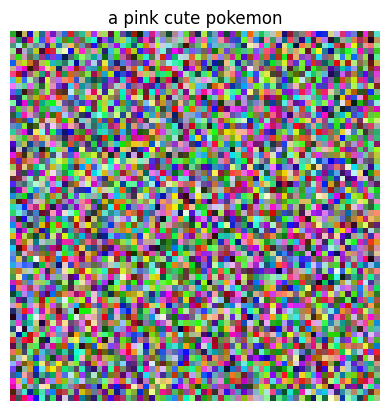

In [20]:
def generate_pokemon(prompt):
    text_tokens = text_vectorizer([prompt])
    vis_tokens = generate_image_tokens(
        transformer_model,
        text_tokens
    )
    image = decode_to_real_image(vis_tokens)

    plt.imshow(image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
generate_pokemon("a pink cute pokemon")